In [1]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [2]:
import numpy as np
import scipy as sp
import math
import torch
import optuna
import torch.autograd as autograd
import matplotlib.pyplot as plt
import inspect
import textwrap

from typing import Callable
from torch import nn, optim
from sklearn.model_selection import KFold
from data_PINN import diffeq, create_trainig_test_set, create_trainig_validation_test_set

import torch.nn.functional as F

torch.use_deterministic_algorithms(True)

In [3]:
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"

print(device)

cuda


## Defining the differential equation

We are using the differential equation of a harmonic oscillator:

$m \frac{d^2 x}{dt^2} +kx = 0$

In [4]:
#Define the harmonic oscillator

def f(t,x,k):
    #write the function that is on the other side of the differential equation
    return -k*x

def differential_equation_1_order(t, x, k):
    dx_dt = f(t,x,k)
    return dx_dt

def differential_equation_2_order(t, X, k):
    #rewrite d^2x/dt^2 as dy/dt where y=dx/dt
    x, y = X
    dx_dt = y
    dy_dt = f(t,x,k)

    return [dx_dt, dy_dt]

# 1. First try

## Generating datasets

TODO: implement data generation with analytical solution

In [6]:
#define the harmonic oscillator class (which ode's, number of variables: x,y, number of arguments: k)
harmonic_osc = diffeq(differential_equation_2_order, 2, 1)

#create training and test datasets (which diffeq, timespan, how many timesteps, how many initial conditions (datasets with each 100 timepoints), fraction of test sets, which numerical method to compare, which device, random seed to create data)
train, test = create_trainig_test_set(harmonic_osc, (0, 10), 100, 1000, 0.3, "analytic_harmonic", device=device, seed=0)

#note: device:cuda did not work

In [6]:
print(train["X"].shape)
print(train["y_tensor"][0:, 0:, 0].unsqueeze(-1).shape)
print(train["t_tensor"].shape)
print(train["args_tensor"].shape)

torch.Size([700, 100, 4])
torch.Size([700, 100, 1])
torch.Size([700, 100])
torch.Size([700, 1])


In [7]:
class HarmonicModel(nn.Module):
    def __init__(self, n_in):
        super().__init__()
        self.linear = nn.Linear(in_features=n_in, out_features=32)
        self.linear2 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.tanh(self.linear(x))
        x = self.linear2(x)
        return x

# Initiate the model
model = HarmonicModel(4).to(device)

In [8]:
def loss_PINN(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)

    t_f = torch.linspace(0, 100, steps=N_f).repeat(len(t), 1).unsqueeze(-1).requires_grad_(True).to(device)

    n_rep = int(N_f / len(y_exp[0]))

    k_f = k.unsqueeze(-1).repeat(1, n_rep, 1)
    x_00_f = x_00.unsqueeze(-1).repeat(1, n_rep, 1)
    x_01_f = x_01.unsqueeze(-1).repeat(1, n_rep, 1)

    X_f = torch.cat([k_f, x_00_f, x_01_f, t_f], dim=-1)
    
    y_f = model(X_f)
    x_t = autograd.grad(y_f, t_f,
                       grad_outputs=torch.ones_like(y_f),
                       create_graph=True, allow_unused=True)[0]
    
    x_tt = autograd.grad(x_t, t_f,
                        grad_outputs=torch.ones_like(x_t),
                        create_graph=True, allow_unused=True)[0]
    
    # Residual
    f_res = x_tt + k_f*y_f
    mse_f = torch.mean(f_res**2)

    return mse_y + mse_f

In [9]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [10]:
epochs = 1000

for epoch in range(epochs):
    X = train["X"]
    y_exp = train["y_tensor"][0:, 0:, 0].to(device)
    y_pred = model(X).squeeze(-1)
    t = X[0:, 0:, 3]
    k = X[0:, 0:, 0]
    x_00 = X[0:, 0:, 1]
    x_01 = X[0:, 0:, 2]

    loss = loss_PINN(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)

    optimizer.zero_grad()
    loss.backward()
    
    optimizer.step()

    if (epoch+1) % (int(epochs/10)) == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

/home/izpodperda/University/Master/MachineLearning/Project/Machine-learning-project/.venv/lib/python3.12/site-packages/torch/autograd/graph.py:829: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:179.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 100/1000, Loss: 0.5821
Epoch 200/1000, Loss: 0.4133
Epoch 300/1000, Loss: 0.2281
Epoch 400/1000, Loss: 0.1715
Epoch 500/1000, Loss: 0.1228
Epoch 600/1000, Loss: 0.1019
Epoch 700/1000, Loss: 0.0902
Epoch 800/1000, Loss: 0.0820
Epoch 900/1000, Loss: 0.0744
Epoch 1000/1000, Loss: 0.0688


In [11]:
model.eval()
X = test["X"]
y_exp = test["y_tensor"][0:, 0:, 0].to(device)
y_pred = model(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
#print(T_pred_test)
test_loss = loss_PINN(y_pred, y_exp, x_00, x_01, t, k, N_f=100)
print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0848


torch.Size([300, 100])


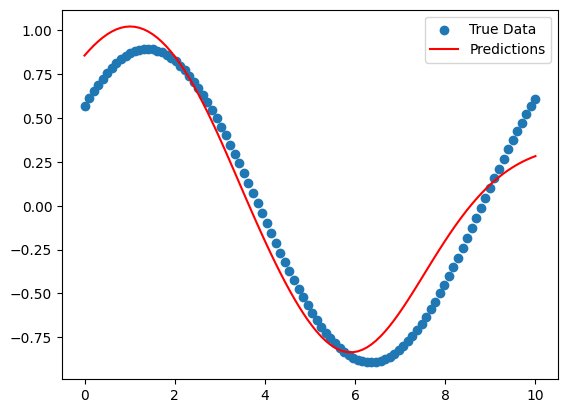

In [12]:
print(y_pred.shape)
y_pred.to("cpu")
test["t_tensor"].to("cpu")

n = 30
plt.scatter(test["t_tensor"][n], test["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test["t_tensor"][n], y_pred.cpu().detach()[n], color="red", label="Predictions")
plt.legend()
plt.show()

# 2. Hyperparameter optimization using random search

## Generating datasets

In [13]:
train2, validation2, test2 = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1000, [0.5, 0.2, 0.3], "analytic_harmonic", device=device, seed=0)

In [14]:
print(train2["X"].shape)
print(validation2["X"].shape)
print(test2["X"].shape)

torch.Size([500, 100, 4])
torch.Size([200, 100, 4])
torch.Size([300, 100, 4])


## Defining the model

A model receives the number of initial parameters n_i, the number of hidden layers n_layers, number of neurons per layer and the activation function.

TODO: implement different number of neurons for each layer, coefficients for loss terms, learning rate

In [15]:
class HarmonicModel2(nn.Module):
    def __init__(self, n_in, n_layers, n_neurons, activation):
        super().__init__()
        layers = []
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }[activation]
        
        layers.append(nn.Linear(n_in, n_neurons))
        for _ in range(n_layers - 1):
            layers.append(nn.Linear(n_neurons, n_neurons))
        layers.append(nn.Linear(n_neurons, 1))
        
        self.layers = nn.ModuleList(layers)
        self.activation = act

    def forward(self, x):
        for layer in self.layers[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.layers[-1](x)

# test model
model = HarmonicModel2(4, 2, 32, 'tanh').to(device)

In [16]:
def loss_PINN2(y_pred, y_exp, x_00, x_01, t, k, N_f):
    mse_y = torch.mean((y_pred - y_exp)**2)

    t_f = torch.linspace(0, 100, steps=N_f).repeat(len(t), 1).unsqueeze(-1).requires_grad_(True).to(device)

    n_rep = int(N_f / len(y_exp[0]))

    k_f = k.unsqueeze(-1).repeat(1, n_rep, 1)
    x_00_f = x_00.unsqueeze(-1).repeat(1, n_rep, 1)
    x_01_f = x_01.unsqueeze(-1).repeat(1, n_rep, 1)

    X_f = torch.cat([k_f, x_00_f, x_01_f, t_f], dim=-1)
    
    y_f = model(X_f)
    x_t = autograd.grad(y_f, t_f,
                       grad_outputs=torch.ones_like(y_f),
                       create_graph=True, allow_unused=True)[0]
    
    x_tt = autograd.grad(x_t, t_f,
                        grad_outputs=torch.ones_like(x_t),
                        create_graph=True, allow_unused=True)[0]
    
    # Residual
    f_res = x_tt + k_f*y_f
    mse_f = torch.mean(f_res**2)

    return mse_y + mse_f

In [17]:
def train_PINN2(model, lr, epochs, data):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    X = data["X"]
    y_exp = data["y_tensor"][0:, 0:, 0].to(device)

    for epoch in range(epochs):
        y_pred = model(X).squeeze(-1)
        t = X[0:, 0:, 3]
        k = X[0:, 0:, 0]
        x_00 = X[0:, 0:, 1]
        x_01 = X[0:, 0:, 2]
    
        loss = loss_PINN2(y_pred, y_exp, x_00, x_01, t, k, N_f=1000)
    
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
        # if (epoch+1) % (int(epochs/10)) == 0:
        #     print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return loss.item()



## Optimizing hyperparemeters

In [18]:
#layers_i, neurons_i, ... = interval of randomized values
def rng_hparameters_search(n_trials, layers_i: tuple, neurons_i: tuple, activations_l: list, data, seed=0):
    result = []
    torch.manual_seed(seed)
    layers = torch.randint(layers_i[0], layers_i[-1], (n_trials,)).to(device)
    neurons = torch.randint(neurons_i[0], neurons_i[-1], (n_trials,)).to(device)
    activations_idx = torch.randint(0, len(activations_l), (n_trials,)).to(device)
    activations = [activations_l[i] for i in activations_idx]

    for i in range(n_trials):
        params = {
            'n_layers': layers[i],
            'n_neurons': neurons[i],
            'activation': activations[i]
        }

        model = HarmonicModel2(4, params['n_layers'].item(), params['n_neurons'].item(), params['activation']).to(device)
        final_loss = train_PINN2(model, 0.01, 100, data)
        result.append((params, final_loss))

        if (i+1) % (int(n_trials/10)) == 0:
            print(f'{i+1}/{n_trials}')
    
    return result

In [19]:
n_trials = 100
results = rng_hparameters_search(n_trials, (1, 10), (1, 100), ['tanh', 'sine', 'gelu', 'relu'], validation2, seed=0)

10/100
20/100
30/100
40/100
50/100
60/100
70/100
80/100
90/100
100/100


In [20]:
best_params, best_loss = min(results, key=lambda x: x[1])
print("\nBest configuration:")
print(best_params)
print(f"Final loss: {best_loss:.3e}")


Best configuration:
{'n_layers': tensor(6, device='cuda:0'), 'n_neurons': tensor(72, device='cuda:0'), 'activation': 'sine'}
Final loss: 3.988e-02


Best configuration:
{'n_layers': tensor(6, device='cuda:0'), 'n_neurons': tensor(60, device='cuda:0'), 'activation': 'sine'}
Final loss: 1.515e-02


## Testing found hyperparameters

In [21]:
model_optimized = HarmonicModel2(4, 6, 60, 'sine').to(device)

In [22]:
# training
loss_last = train_PINN2(model_optimized, 0.01, 1000, train2)

In [23]:
# test dataset
model_optimized.eval()
X = test2["X"]
y_exp = test2["y_tensor"][0:, 0:, 0].to(device)
y_pred = model_optimized(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
#print(T_pred_test)
test_loss = loss_PINN2(y_pred, y_exp, x_00, x_01, t, k, N_f=100)
print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0234


torch.Size([300, 100])


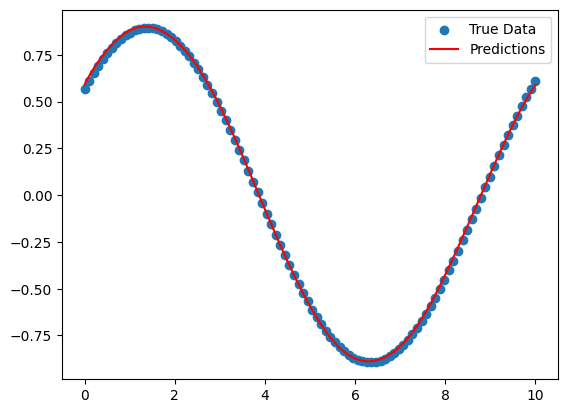

In [24]:
print(y_pred.shape)
y_pred.to("cpu")
test2["t_tensor"].to("cpu")

n = 30
plt.scatter(test2["t_tensor"][n], test2["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test2["t_tensor"][n], y_pred.cpu().detach()[n], color="red", label="Predictions")
plt.legend()
plt.show()

# 3. Hyperparameter optimization using Optuna

## Generating datasets

In [7]:
train3, validation3, test3 = create_trainig_validation_test_set(harmonic_osc, (0, 10), 100, 1000, [0.5, 0.2, 0.3], "analytic_harmonic", device=device, seed=0)

In [8]:
print(train3["X"].shape)
print(validation3["X"].shape)
print(test3["X"].shape)

torch.Size([500, 100, 4])
torch.Size([200, 100, 4])
torch.Size([300, 100, 4])


## Defining the model

In [9]:
class HarmonicModel3(nn.Module):
    def __init__(self, n_in: int, n_hidden_layers: int, hidden_neurons: list, activation: str):
        super().__init__()
        layers = []
        act = {
            'tanh': nn.Tanh(),
            'sine': torch.sin,
            'gelu': nn.GELU(),
            'relu': nn.ReLU()
        }[activation]
        
        layers.append(nn.Linear(n_in, hidden_neurons[0]))
        for i in range(n_hidden_layers - 1):
            layers.append(nn.Linear(hidden_neurons[i], hidden_neurons[i+1]))
        layers.append(nn.Linear(hidden_neurons[-1], 1))
        
        self.layers = nn.ModuleList(layers)
        self.activation = act

    def forward(self, x):
        for layer in self.layers[:-1]:
            if callable(self.activation):  # sine special case
                x = self.activation(layer(x))
            else:
                x = self.activation(layer(x))
        return self.layers[-1](x)

# test model
model = HarmonicModel3(4, 5, [32, 16, 8, 4, 2], 'tanh').to(device)
model

HarmonicModel3(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): Linear(in_features=4, out_features=2, bias=True)
    (5): Linear(in_features=2, out_features=1, bias=True)
  )
  (activation): Tanh()
)

In [54]:
def loss_PINN3(model, y_pred, y_exp, x_00, x_01, t, k, N_f, l_y, l_f):
    mse_y = torch.mean((y_pred - y_exp)**2)

    t_f = torch.linspace(0, 100, steps=N_f).repeat(len(t), 1).unsqueeze(-1).requires_grad_(True).to(device)

    n_rep = int(N_f / len(y_exp[0]))

    k_f = k.unsqueeze(-1)[:, 0, :].unsqueeze(-1).repeat(1, N_f, 1)
    x_00_f = x_00.unsqueeze(-1)[:, 0, :].unsqueeze(-1).repeat(1, N_f, 1)
    x_01_f = x_01.unsqueeze(-1)[:, 0, :].unsqueeze(-1).repeat(1, N_f, 1)

    X_f = torch.cat([k_f, x_00_f, x_01_f, t_f], dim=-1)
    
    y_f = model(X_f)
    x_t = autograd.grad(y_f, t_f,
                       grad_outputs=torch.ones_like(y_f),
                       create_graph=True, allow_unused=True)[0]
    
    x_tt = autograd.grad(x_t, t_f,
                        grad_outputs=torch.ones_like(x_t),
                        create_graph=True, allow_unused=True)[0]
    
    # Residual
    f_res = x_tt + k_f*y_f
    mse_f = torch.mean(f_res**2)

    return l_y*mse_y + l_f*mse_f

In [55]:
def train_PINN3(model_class, model_args, n_splits, l_y, l_f, optimizer_class, lr, epochs, N_f, data, random_state=0, show_progress=False):
    """
    optimizer_class: e.g. optim.Adam or optim.SGD
    """
    X_full = data["X"]
    y_exp_full = data["y_tensor"][0:, 0:, 0].to(device)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    fold_losses = []

    best_model = None
    best_loss = float("inf")

    #K-fold loop
    for fold_id, (train_idx, val_idx) in enumerate(kf.split(X_full)):
        if show_progress:
            print(f'-----Fold: {fold_id + 1}-----')
        
        X_train = X_full[train_idx].to(device)
        y_train = y_exp_full[train_idx]
        X_val = X_full[val_idx].to(device)
        y_val = y_exp_full[val_idx]

        #New model every fold
        model = model_class(*model_args).to(device)
        optimizer = optimizer_class(model.parameters(), lr=lr)

        #Training
        for epoch in range(epochs):
            model.train()
            
            y_pred = model(X_train).squeeze(-1)
            t = X_train[0:, 0:, 3]
            k = X_train[0:, 0:, 0]
            x_00 = X_train[0:, 0:, 1]
            x_01 = X_train[0:, 0:, 2]
        
            loss = loss_PINN3(model, y_pred, y_train, x_00, x_01, t, k, N_f, l_y, l_f)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch+1) % (int(epochs/10)) == 0 and show_progress:
                print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

        #Validation
        model.eval()
        #with torch.no_grad():
        y_pred_val = model(X_val).squeeze(-1)
        t_val = X_val[0:, 0:, 3]
        k_val = X_val[0:, 0:, 0]
        x00_val = X_val[0:, 0:, 1]
        x01_val = X_val[0:, 0:, 2]

        val_loss = loss_PINN3(model, y_pred_val, y_val, x00_val, x01_val, t_val, k_val, N_f, l_y, l_f).item()
        if show_progress:
            print(f'\tValidation loss = {val_loss}')

        #Track best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

        #Free vram
        del model
        del optimizer
        torch.cuda.empty_cache()
        torch.cuda.synchronize()


    return best_model, best_loss



### Testing previous best model

In [57]:
torch.cuda.empty_cache()

best_model, best_loss = train_PINN3(HarmonicModel3, 
                                    (4, 6, [60, 60, 60, 60, 60, 60], 'sine'), 
                                    n_splits=5,
                                    l_y=1,
                                    l_f=1,
                                    optimizer_class=torch.optim.Adam, 
                                    lr=0.01, 
                                    epochs=1000, 
                                    N_f=150, 
                                    data=train3, 
                                    random_state=0,
                                    show_progress=True
                                   )

-----Fold: 1-----
Epoch 100/1000, Loss: 0.0579
Epoch 200/1000, Loss: 0.0120
Epoch 300/1000, Loss: 0.0075
Epoch 400/1000, Loss: 0.0039
Epoch 500/1000, Loss: 0.0025
Epoch 600/1000, Loss: 0.0107
Epoch 700/1000, Loss: 0.0041
Epoch 800/1000, Loss: 0.0020
Epoch 900/1000, Loss: 0.0054
Epoch 1000/1000, Loss: 0.0021
	Validation loss = 0.0025657517835497856
-----Fold: 2-----
Epoch 100/1000, Loss: 0.0439
Epoch 200/1000, Loss: 0.0136
Epoch 300/1000, Loss: 0.0125
Epoch 400/1000, Loss: 0.0055
Epoch 500/1000, Loss: 0.0054
Epoch 600/1000, Loss: 0.0078
Epoch 700/1000, Loss: 0.0041
Epoch 800/1000, Loss: 0.0090
Epoch 900/1000, Loss: 0.0047
Epoch 1000/1000, Loss: 0.0037
	Validation loss = 0.005520832259207964
-----Fold: 3-----
Epoch 100/1000, Loss: 0.0785
Epoch 200/1000, Loss: 0.0090
Epoch 300/1000, Loss: 0.0052
Epoch 400/1000, Loss: 0.0039
Epoch 500/1000, Loss: 0.0037
Epoch 600/1000, Loss: 0.0028
Epoch 700/1000, Loss: 0.0022
Epoch 800/1000, Loss: 0.0020
Epoch 900/1000, Loss: 0.0017
Epoch 1000/1000, Loss:

In [58]:
best_model, best_loss

(HarmonicModel3(
   (layers): ModuleList(
     (0): Linear(in_features=4, out_features=60, bias=True)
     (1-5): 5 x Linear(in_features=60, out_features=60, bias=True)
     (6): Linear(in_features=60, out_features=1, bias=True)
   )
 ),
 0.0024356828071177006)

In [59]:
# test dataset
best_model.eval()
X = test3["X"]
y_exp = test3["y_tensor"][0:, 0:, 0].to(device)
y_pred = best_model(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
#print(T_pred_test)
test_loss = loss_PINN3(best_model, y_pred, y_exp, x_00, x_01, t, k, N_f=100, l_y=1, l_f=1)
print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0096


torch.Size([300, 100])


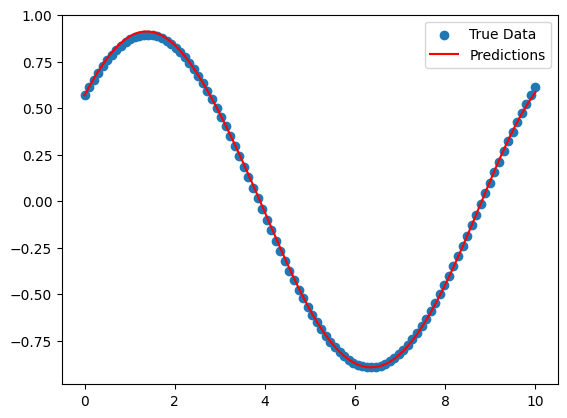

In [60]:
print(y_pred.shape)
y_pred.to("cpu")
test3["t_tensor"].to("cpu")

n = 30
plt.scatter(test3["t_tensor"][n], test3["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test3["t_tensor"][n], y_pred.cpu().detach()[n], color="red", label="Predictions")
plt.legend()
plt.show()

## Optimizing hyperparameters

Some of the parameters are held constant to minimize the number of iterations (they won't be kept constant for the final work)

In [61]:
def objective(trial):

    #Model hyperparemeters
    n_hidden_layers = trial.suggest_int("n_hidden_layers", 2, 5)
    hidden_neurons = [trial.suggest_int(f"n_neurons{i}", 4, 128, log=True) for i in range(n_hidden_layers)]
    activation = trial.suggest_categorical("activation", ["tanh", "sine", "relu", "gelu"])
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)

    #Loss function hyperparameters
    l_y = trial.suggest_float("l_y", 0.1, 10.0, log=True)
    l_f = trial.suggest_float("l_f", 0.1, 10.0, log=True)
    N_f = trial.suggest_int("N_f", 50, 300) #to change

    #Training hyperparameters
    epochs = trial.suggest_int("epochs", 10, 200) #to change
    n_splits = trial.suggest_int("n_splits", 2, 10)
    optimizers = [torch.optim.Adam, torch.optim.SGD, 
                  torch.optim.RMSprop, torch.optim.Adagrad,
                  torch.optim.ASGD, torch.optim.Rprop]
    optimizer_idx = trial.suggest_int("optimizer_idx", 0, len(optimizers) - 1)
    optimizer_class = optimizers[optimizer_idx]

    model_args = (4, n_hidden_layers, hidden_neurons, activation)

    #Training using K-fold
    best_model, best_loss = train_PINN3(
        model_class=HarmonicModel3,
        model_args=model_args,
        n_splits=5,
        l_y=1,
        l_f=1,
        optimizer_class=optimizer_class,
        lr=lr,
        epochs=100,
        N_f=N_f,
        data=train3,
        random_state=trial.number,
        show_progress=False
    )

    return best_loss

In [62]:
study = optuna.create_study(
    sampler=optuna.samplers.TPESampler(seed=0),
    study_name="PINN_harmonic_oscillator",
    direction="minimize",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=2, n_warmup_steps=10)
)

study.optimize(objective, n_trials=50, n_jobs=1, show_progress_bar=True)

[I 2025-12-07 22:35:00,419] A new study created in memory with name: PINN_harmonic_oscillator


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-12-07 22:35:13,342] Trial 0 finished with value: 0.5976191759109497 and parameters: {'n_hidden_layers': 4, 'n_neurons0': 46, 'n_neurons1': 31, 'n_neurons2': 25, 'n_neurons3': 16, 'activation': 'gelu', 'lr': 0.0005846326121643416, 'l_y': 3.832216850492789, 'l_f': 1.1423254155608376, 'N_f': 192, 'epochs': 186, 'n_splits': 2, 'optimizer_idx': 0}. Best is trial 0 with value: 0.5976191759109497.
[I 2025-12-07 22:35:17,786] Trial 1 finished with value: 0.28079354763031006 and parameters: {'n_hidden_layers': 2, 'n_neurons0': 70, 'n_neurons1': 58, 'activation': 'sine', 'lr': 0.0036396393567863887, 'l_y': 0.17240460099242294, 'l_f': 1.9047678084282036, 'N_f': 85, 'epochs': 190, 'n_splits': 6, 'optimizer_idx': 2}. Best is trial 1 with value: 0.28079354763031006.
[I 2025-12-07 22:35:24,518] Trial 2 finished with value: 0.6794627904891968 and parameters: {'n_hidden_layers': 3, 'n_neurons0': 57, 'n_neurons1': 18, 'n_neurons2': 27, 'activation': 'sine', 'lr': 0.007717846862118065, 'l_y': 2.3

In [63]:
print("Best hyperparameters:", study.best_trial.params)
print("Best value:", study.best_value)

Best hyperparameters: {'n_hidden_layers': 5, 'n_neurons0': 88, 'n_neurons1': 19, 'n_neurons2': 21, 'n_neurons3': 66, 'n_neurons4': 26, 'activation': 'gelu', 'lr': 0.00845442558392455, 'l_y': 2.022672619394249, 'l_f': 0.26633382346734336, 'N_f': 174, 'epochs': 124, 'n_splits': 7, 'optimizer_idx': 5}
Best value: 0.006781794596463442


## Testing new best hyperparameters

In [64]:
torch.cuda.empty_cache()

best_model_new, best_loss_new = train_PINN3(HarmonicModel3, 
                                    (4, 5, [88, 19, 21, 66, 26], 'gelu'), 
                                    n_splits=5,
                                    l_y=1,
                                    l_f=1,
                                    optimizer_class=torch.optim.Rprop, 
                                    lr=0.00845442558392455, 
                                    epochs=1000, 
                                    N_f=174, 
                                    data=train3, 
                                    random_state=0,
                                    show_progress=True
                                   )

-----Fold: 1-----
Epoch 100/1000, Loss: 0.0100
Epoch 200/1000, Loss: 0.0028
Epoch 300/1000, Loss: 0.0020
Epoch 400/1000, Loss: 0.0017
Epoch 500/1000, Loss: 0.0015
Epoch 600/1000, Loss: 0.0014
Epoch 700/1000, Loss: 0.0013
Epoch 800/1000, Loss: 0.0012
Epoch 900/1000, Loss: 0.0012
Epoch 1000/1000, Loss: 0.0011
	Validation loss = 0.0015507314819842577
-----Fold: 2-----
Epoch 100/1000, Loss: 0.0131
Epoch 200/1000, Loss: 0.0036
Epoch 300/1000, Loss: 0.0022
Epoch 400/1000, Loss: 0.0017
Epoch 500/1000, Loss: 0.0015
Epoch 600/1000, Loss: 0.0013
Epoch 700/1000, Loss: 0.0012
Epoch 800/1000, Loss: 0.0012
Epoch 900/1000, Loss: 0.0011
Epoch 1000/1000, Loss: 0.0010
	Validation loss = 0.0013836389407515526
-----Fold: 3-----
Epoch 100/1000, Loss: 0.0133
Epoch 200/1000, Loss: 0.0039
Epoch 300/1000, Loss: 0.0025
Epoch 400/1000, Loss: 0.0019
Epoch 500/1000, Loss: 0.0016
Epoch 600/1000, Loss: 0.0015
Epoch 700/1000, Loss: 0.0013
Epoch 800/1000, Loss: 0.0013
Epoch 900/1000, Loss: 0.0012
Epoch 1000/1000, Loss

In [65]:
best_model_new, best_loss_new

(HarmonicModel3(
   (layers): ModuleList(
     (0): Linear(in_features=4, out_features=88, bias=True)
     (1): Linear(in_features=88, out_features=19, bias=True)
     (2): Linear(in_features=19, out_features=21, bias=True)
     (3): Linear(in_features=21, out_features=66, bias=True)
     (4): Linear(in_features=66, out_features=26, bias=True)
     (5): Linear(in_features=26, out_features=1, bias=True)
   )
   (activation): GELU(approximate='none')
 ),
 0.0012319621164351702)

In [66]:
# test dataset
best_model_new.eval()
X = test3["X"]
y_exp = test3["y_tensor"][0:, 0:, 0].to(device)
y_pred = best_model_new(X).squeeze(-1)
t = X[0:, 0:, 3]
k = X[0:, 0:, 0]
x_00 = X[0:, 0:, 1]
x_01 = X[0:, 0:, 2]
#print(T_pred_test)
test_loss = loss_PINN3(best_model_new, y_pred, y_exp, x_00, x_01, t, k, N_f=100, l_y=1, l_f=1)
print(f"Test Loss: {test_loss.item():.4f}")

Test Loss: 0.0023


torch.Size([300, 100])


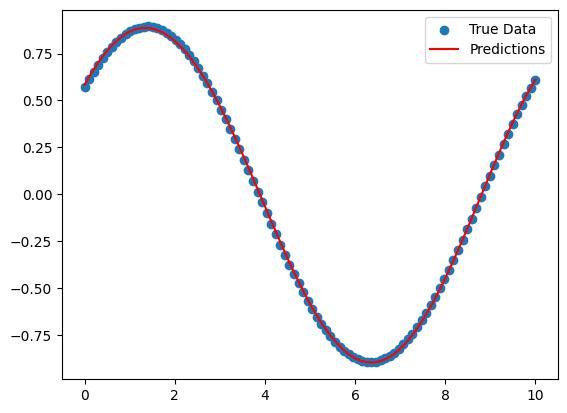

In [67]:
print(y_pred.shape)
y_pred.to("cpu")
test3["t_tensor"].to("cpu")

n = 30
plt.scatter(test3["t_tensor"][n], test3["y_tensor"][n][0:, 0], label="True Data")
plt.plot(test3["t_tensor"][n], y_pred.cpu().detach()[n], color="red", label="Predictions")
plt.legend()
plt.show()